In [1]:
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt


dataset = "groupon"
#dataset = "horse"
#dataset = "nhanes"

data = pd.read_parquet(f"/Users/andres.hoyosidrobo/Downloads/pairing/experiment/{dataset}/results.parquet")
print(data.head())
print(data.columns)

                                 matching         diff       smd   n0   n1  \
0                            bart_nearest -3455.037799  0.411307  216  216   
1                            bart_optimal   145.374465  0.033780  216  216   
2  bipartify_identity_logistic-regression  -624.085886  0.039126  216  216   
3                bipartify_identity_psmpy  -834.432669  0.054010  216  216   
4        bipartify_identity_random-forest  -588.261970  0.051034  216  216   

        target       split_id                                         method  
0 -2403.611111  matchitrealxp                            matchitbart_nearest  
1 -3946.768519  matchitrealxp                            matchitbart_optimal  
2 -3821.546296  matchitrealxp  matchitbipartify_identity_logistic-regression  
3 -3058.578704  matchitrealxp                matchitbipartify_identity_psmpy  
4 -3993.708333  matchitrealxp        matchitbipartify_identity_random-forest  
Index(['matching', 'diff', 'smd', 'n0', 'n1', 'target', '

In [2]:
ate = data['diff'].abs().values
smd = data["smd"].values

points = np.hstack([ate[:, np.newaxis], smd[:, np.newaxis]])
df_points = pd.DataFrame(points, columns=['ate', 'smd'])

# Min norm selection

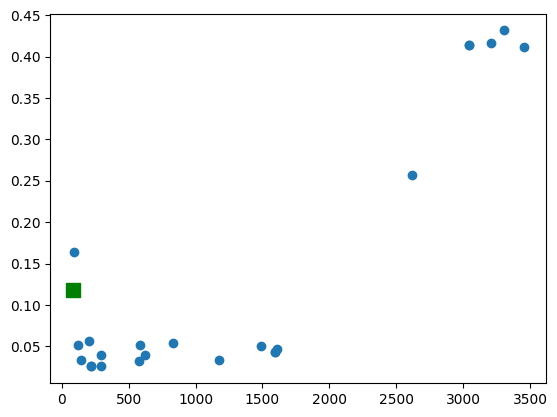

In [3]:
norms = np.linalg.norm(points, axis=1)

selected = norms == norms.min()

plt.scatter(points[:, 0], points[:, 1])
plt.scatter(points[selected, 0], points[selected, 1], color="g", marker="s", s=100)

# Max curvature selection

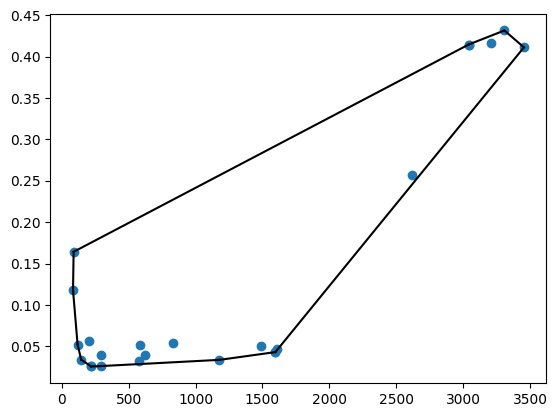

In [4]:
from scipy.spatial import ConvexHull


hull = ConvexHull(points)

plt.plot(points[:,0], points[:,1], 'o')

for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'k-')

In [5]:
vertex = np.vstack([points[s] for s in hull.simplices])
df_vertex = pd.DataFrame(vertex, columns=['ate', 'smd'])
vv = df_vertex.sort_values('ate').drop_duplicates().values

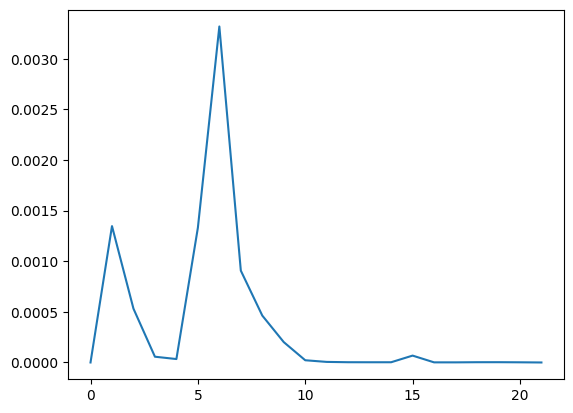

In [6]:
from scipy.interpolate import CubicSpline
from typing import Callable


def get_curvature(
    cs: Callable, 
    x: np.ndarray,
) -> np.ndarray:
    num = np.abs(cs(x, 2)) 
    den = np.float_power(1 + cs(x, 1) ** 2, 1.5)
    return np.nan_to_num(num / den)


pp = df_points.sort_values("ate").drop_duplicates().values

cs = CubicSpline(pp[:, 0], pp[:, 1])
kappa = get_curvature(cs, pp[:, 0])

kappa[0] = 0
kappa[-1] = 0

plt.plot(kappa)

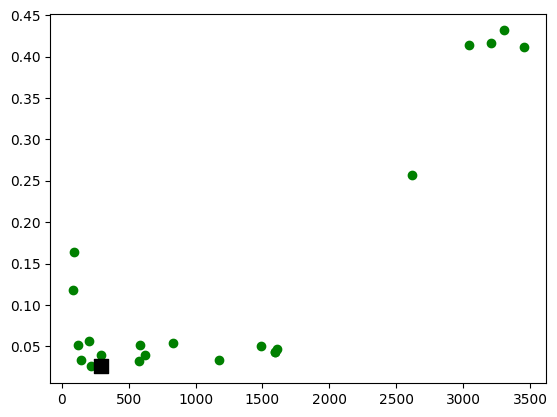

In [7]:
kappa_id = kappa == kappa.max()

plt.scatter(pp[:, 0], cs(pp[:, 0]), color='g')

plt.scatter(pp[kappa_id, 0], pp[kappa_id, 1], color='k', s=100, marker='s')